In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

In [3]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Random rotations
    width_shift_range=0.1,  # Random horizontal shifts
    height_shift_range=0.1,  # Random vertical shifts
    shear_range=0.1,  # Shear transformations
    zoom_range=0.1,  # Random zoom
    horizontal_flip=True,  # Random horizontal flips
    fill_mode='nearest',
    validation_split=0.2
)


train_data = data_gen.flow_from_directory(
    'C:\\Users\\sarow\\OneDrive\\Desktop\\CS535_Project\\train',
    target_size=(224, 224),  # ResNet-50 expects 224x224 images
    batch_size=16,
    class_mode='binary',
    color_mode='rgb',  # Convert grayscale to 3 channels
    subset='training'
)

val_data = data_gen.flow_from_directory(
    'C:\\Users\\sarow\\OneDrive\\Desktop\\CS535_Project\\train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    color_mode='rgb',
    subset='validation'
)

test_data = data_gen.flow_from_directory(
    'C:\\Users\\sarow\\OneDrive\\Desktop\\CS535_Project\\test',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)


Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [4]:
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False  # Freeze the base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Use dropout to add regularization
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint('C:\\Users\\sarow\\OneDrive\\Desktop\\CS535_Project\\best_cs_535_model.h5', save_best_only=True)

# Add this before model.fit()
model_checkpoint_callback = ModelCheckpoint(
    filepath='C:\\Users\\sarow\\OneDrive\\Desktop\\CS535_Project\\best_cs_535_model.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_learning_rate=0.0001,
    verbose=1
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[model_checkpoint_callback, reduce_learning_rate]
)

model.save('C:\\Users\\sarow\\OneDrive\\Desktop\\CS535_Project\\final_cs_535_resnet_model.h5')



# Then add 'model_checkpoint_callback' to the callbacks list in model.fit()


Epoch 1/50


400/400 [==============================] - ETA: 0s - loss: 0.6316 - accuracy: 0.6522
Epoch 1: val_loss improved from inf to 0.49804, saving model to C:\Users\sarow\OneDrive\Desktop\CS535_Project\best_cs_535_model.h5


C:\Users\sarow\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


400/400 [==============================] - 573s 1s/step - loss: 0.6316 - accuracy: 0.6522 - val_loss: 0.4980 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 2/50
400/400 [==============================] - ETA: 0s - loss: 0.5367 - accuracy: 0.7278
Epoch 2: val_loss did not improve from 0.49804
400/400 [==============================] - 490s 1s/step - loss: 0.5367 - accuracy: 0.7278 - val_loss: 0.5182 - val_accuracy: 0.7337 - lr: 0.0010
Epoch 3/50
400/400 [==============================] - ETA: 0s - loss: 0.5046 - accuracy: 0.7598
Epoch 3: val_loss improved from 0.49804 to 0.44200, saving model to C:\Users\sarow\OneDrive\Desktop\CS535_Project\best_cs_535_model.h5
400/400 [==============================] - 488s 1s/step - loss: 0.5046 - accuracy: 0.7598 - val_loss: 0.4420 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 4/50
400/400 [==============================] - ETA: 0s - loss: 0.5063 - accuracy: 0.7528
Epoch 4: val_loss did not improve from 0.44200
400/400 [==============================] - 526s 

In [6]:
# Unfreeze some of the base model layers
base_model.trainable = True
fine_tune_at = 100  # This is the number of layers from the top to fine-tune

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model with a low learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training
history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,  # Continue for more epochs
    callbacks=[model_checkpoint_callback, reduce_learning_rate]
)


Epoch 1/25
400/400 [==============================] - ETA: 0s - loss: 17.9110 - accuracy: 0.7148
Epoch 1: val_loss did not improve from 0.30041
400/400 [==============================] - 472s 1s/step - loss: 17.9110 - accuracy: 0.7148 - val_loss: 0.7343 - val_accuracy: 0.8181 - lr: 1.0000e-05
Epoch 2/25
400/400 [==============================] - ETA: 0s - loss: 0.6468 - accuracy: 0.7670
Epoch 2: val_loss did not improve from 0.30041
400/400 [==============================] - 460s 1s/step - loss: 0.6468 - accuracy: 0.7670 - val_loss: 0.4468 - val_accuracy: 0.8425 - lr: 1.0000e-05
Epoch 3/25
400/400 [==============================] - ETA: 0s - loss: 0.4684 - accuracy: 0.7947
Epoch 3: val_loss did not improve from 0.30041
400/400 [==============================] - 461s 1s/step - loss: 0.4684 - accuracy: 0.7947 - val_loss: 0.4630 - val_accuracy: 0.8213 - lr: 1.0000e-05
Epoch 4/25
400/400 [==============================] - ETA: 0s - loss: 0.4237 - accuracy: 0.8141
Epoch 4: val_loss did not 

In [7]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

# Predict on the test set
predictions = (model.predict(test_data) > 0.5).astype(int).flatten()

# True labels
true_labels = test_data.classes

# Detailed metrics
conf_matrix = confusion_matrix(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
accuracy = accuracy_score(true_labels, predictions)

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

125/125 [==============================] - 81s 644ms/step - loss: 0.1462 - accuracy: 0.9445
Test accuracy: 0.9445, Test loss: 0.1462
125/125 [==============================] - 70s 553ms/step
Precision: 0.9786, Recall: 0.9160, F1 Score: 0.9463, Accuracy: 0.9480


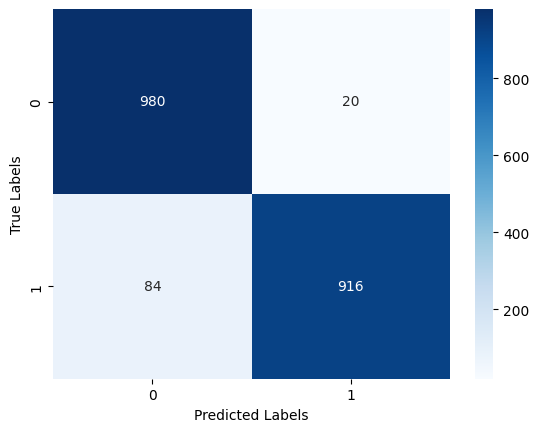

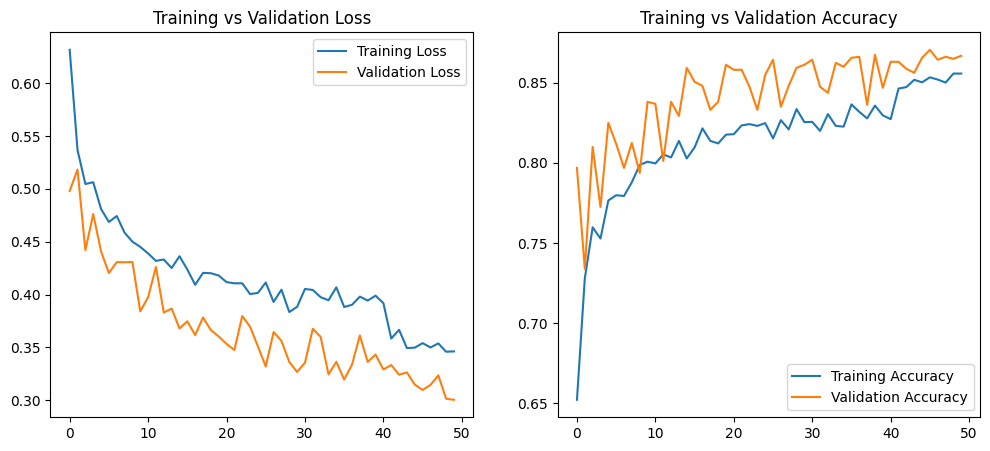

In [8]:
# Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Training History
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()